# Use FRAUD_ANALY_Template Customized Notebook

In [3]:
!pip install --q imbalanced-learn

You should consider upgrading via the 'pip install --upgrade pip' command.


### Restart your Template here

In [1]:
# Statitics and Basic data support
from scipy.stats.mstats import winsorize
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling Training and Tunning
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,precision_score, recall_score, f1_score,log_loss, roc_auc_score,roc_curve, precision_recall_curve
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Imbalance Handling
from imblearn.over_sampling import SMOTE

# Addititional
from collections import Counter
import joblib

# Fosforml
from fosforml import register_model
from fosforml.constants import MLModelFlavours
from fosforml.model_manager.snowflakesession import get_session

# Warnings
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

/opt/conda/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
my_session = get_session()

In [3]:
df = 'FRAUD_DETECTION_ANALY_MASTER_TABLE'

In [4]:
sf_df = my_session.sql("select * from {}".format(df))

In [5]:
pandas_df = sf_df.to_pandas()

In [6]:
print(pandas_df.isnull().sum())

CREDIT_LIMIT                          0
ACCOUNT_OPENING_DATE                  0
LAST_LOGIN                            0
CUSTOMER_SEGMENT                      0
ACCOUNT_TYPE                          0
DEVICE_USED                           0
NAME                                  0
GENDER                                0
DOB                                   0
AGE                                   0
CUSTOMER_ID                           0
AGE_GROUP                             0
AGE_OF_ACCOUNT                        0
FREQUENCY_OF_TRANSACTIONS             0
CUSTOMER_LOYALTY_SCORE                0
NUMBER_OF_REFUNDS                     0
NUMBER_OF_CHARGEBACKS                 0
CREDIT_UTILIZATION_RATIO              0
CHANGE_IN_SPENDING_BEHAVIOR           0
TRANSACTION_VELOCITY                  0
CUSTOMER_LOYALTY_CATEGORY             0
TIME_SINCE_LAST_TRANSACTION           0
TRANSACTION_ID                        0
TIME                                  0
TRANSACTION_AMOUNT                    0


In [8]:
Original_df = pandas_df.copy()

In [9]:
Original_df

,CREDIT_LIMIT,ACCOUNT_OPENING_DATE,LAST_LOGIN,CUSTOMER_SEGMENT,ACCOUNT_TYPE,DEVICE_USED,NAME,GENDER,DOB,AGE,...,MONTH,ANOMALY_SCORE,FRAUD_INDICATOR,SUSPICIOUS_FLAG,PREVIOUS_FRAUD_REPORTS,CROSS_BORDER_TRANSACTION_INDICATOR,NEW_DEVICE_INDICATOR,ANAMOLY_RISK_CATEGORY,MERCHANT_RISK_CATEGORY,FRAUD_FLAG
0,30000,2017-08-17,2017-08-22,Individual,Business Account,Tablet,Andrea Garcia,Female,1991-09-12,33,...,October,0.66,0,0,2,No,No,High Risk,High Risk,No
1,15000,2017-09-13,2018-02-08,Student,Investment Account,Desktop,Victor Ray,Male,1979-04-25,45,...,February,0.26,0,0,1,No,No,Medium Risk,High Risk,No
2,40000,2017-12-31,2020-11-12,Senior,Investment Account,Tablet,Kelli Lopez,Male,1972-04-04,52,...,December,0.20,0,0,0,No,Yes,Low Risk,Very High Risk,No
3,5000,2017-04-26,2019-05-06,Student,Checking Account,Mobile,Traci Phillips,Male,1990-10-23,34,...,January,0.03,0,1,2,Yes,Yes,Low Risk,Medium Risk,No
4,25000,2019-10-13,2021-10-10,Student,Investment Account,Desktop,Eric Brooks,Female,1995-01-26,29,...,October,0.56,0,0,1,Yes,No,High Risk,Very High Risk,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,10000,2018-04-10,2019-09-06,Business,Checking Account,Other,Carol Bishop,Male,1985-11-28,39,...,June,0.39,0,0,0,No,No,Medium Risk,Low Risk,No
299996,35000,2018-10-24,2018-10-24,Business,Savings Account,Mobile,Cole Jacobson,Male,1960-06-04,64,...,July,0.66,0,0,0,No,No,High Risk,Medium Risk,No
299997,15000,2017-08-24,2017-10-21,Senior,Checking Account,Other,Wendy Bell,Male,1988-03-17,36,...,February,0.53,0,0,0,No,No,High Risk,High Risk,No
299998,5000,2019-12-19,2021-04-09,Senior,Investment Account,Desktop,James Austin,Male,1992-09-13,32,...,November,0.77,0,0,2,No,No,Very High Risk,Very High Risk,No


In [10]:
df = Original_df.drop(["TRANSACTION_ID", "CUSTOMER_ID", "DOB", "NAME", "CITY","COUNTY","STATE","YEAR","QUARTER","MONTH","AGE_GROUP","TRANSACTION_DATE","ACCOUNT_OPENING_DATE","LAST_LOGIN","TIME_OF_DAY","DAY_OF_WEEK","TIME","TIME_SINCE_LAST_TRANSACTION","FRAUD_FLAG"], axis = 1)

In [11]:
CATEGORICAL_COLUMNS = ["MERCHANT_CATEGORY","PAYMENT_METHOD","CUSTOMER_SEGMENT","ACCOUNT_TYPE","DEVICE_USED","TRANSACTION_STATUS","CROSS_BORDER_TRANSACTION_INDICATOR","NEW_DEVICE_INDICATOR","GENDER","ANAMOLY_RISK_CATEGORY","MERCHANT_RISK_CATEGORY","CUSTOMER_LOYALTY_CATEGORY","TRANSACTION_TYPE"]
NUMERICAL_COLUMNS = ["ANOMALY_SCORE","TRANSACTION_AMOUNT","CREDIT_LIMIT","AGE_OF_ACCOUNT","FREQUENCY_OF_TRANSACTIONS","MERCHANT_RISK_SCORE","CUSTOMER_LOYALTY_SCORE","DISTANCE_FROM_HOME_ADDRESS","DISTANCE_FROM_LAST_TRANSACTION","NUMBER_OF_REFUNDS","NUMBER_OF_CHARGEBACKS","CREDIT_UTILIZATION_RATIO",
                     "CHANGE_IN_SPENDING_BEHAVIOR","TRANSACTION_VELOCITY","AGE","SUSPICIOUS_FLAG","PREVIOUS_FRAUD_REPORTS"]
LABEL_COLUMNS = ["FRAUD_INDICATOR"]
DROPPED_COLUMNS = ["TRANSACTION_ID", "CUSTOMER_ID", "DOB", "NAME", "CITY","COUNTY","STATE","YEAR","QUARTER","MONTH","AGE_GROUP","TRANSACTION_DATE","ACCOUNT_OPENING_DATE","LAST_LOGIN","TIME_OF_DAY","DAY_OF_WEEK","TIME","TIME_SINCE_LAST_TRANSACTION","FRAUD_FLAG"]
OUTPUT_COLUMNS = ["PREDICTION"]

In [12]:
# Filter feature columns
feature_columns = CATEGORICAL_COLUMNS + NUMERICAL_COLUMNS
feature_columns = [col for col in feature_columns if col in Original_df.columns]
LABEL_COLUMNS = [col for col in LABEL_COLUMNS if col in Original_df.columns]
 
# Split data into features and labels
X = Original_df[feature_columns + DROPPED_COLUMNS]
y = Original_df[LABEL_COLUMNS].values.ravel()  # Flatten to 1D array for consistency

In [13]:
# Preprocessing for numerical data
numerical_transformer = StandardScaler()

In [14]:
# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [15]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, NUMERICAL_COLUMNS),
        ('cat', categorical_transformer, CATEGORICAL_COLUMNS)
    ])

In [16]:
# Create and train the logistic regression model within a pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])

In [17]:
# splitting data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [18]:
X_train.shape,y_test.shape

((225000, 49), (75000,))

In [19]:
# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.94572


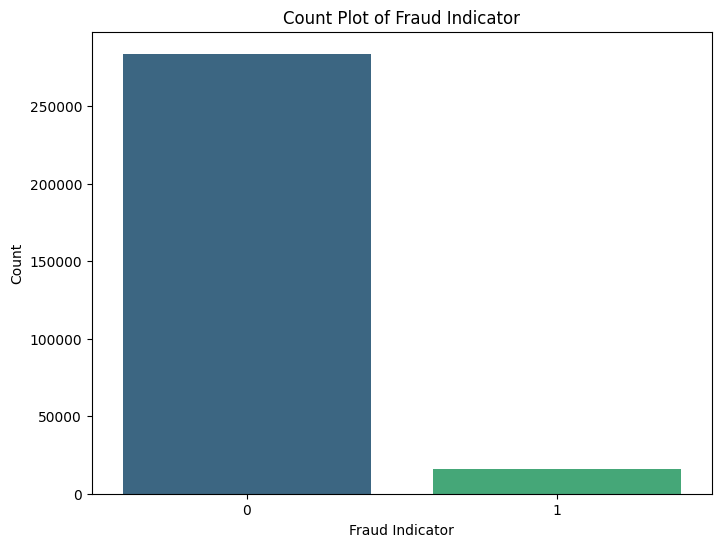

In [20]:
# Assuming your DataFrame is named 'df' and has a column 'FraudIndicator'
# Create a count plot for the 'FraudIndicator' column
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.countplot(data=Original_df, x='FRAUD_INDICATOR', palette='viridis')
plt.title('Count Plot of Fraud Indicator')
plt.xlabel('Fraud Indicator')
plt.ylabel('Count')
plt.show()

In [21]:
# Assuming your DataFrame is named 'df' and has been preprocessed
# Split data into features and labels
X = Original_df[feature_columns]
y = Original_df[LABEL_COLUMNS].values.ravel()  # Flatten to 1D array for consistency

# Apply preprocessing to the data
X_preprocessed = preprocessor.fit_transform(X)

# Initialize SMOTE for oversampling
smote = SMOTE(random_state=42)

# Apply SMOTE to the data
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

Class distribution after oversampling: Counter({0: 283877, 1: 283877})


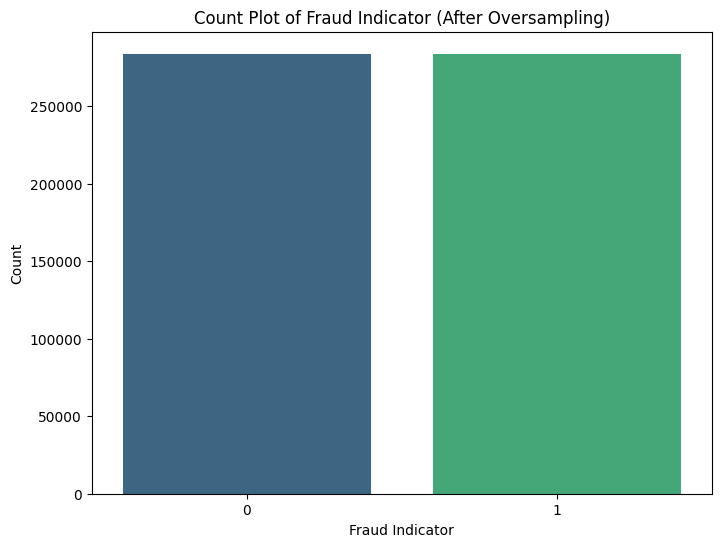

In [21]:
print("Class distribution after oversampling:", Counter(y_resampled))

# Create a count plot for the 'FRAUD_INDICATOR' column after oversampling
plt.figure(figsize=(8, 6))
sns.countplot(data=pd.DataFrame({'FRAUD_INDICATOR': y_resampled}), x='FRAUD_INDICATOR', palette='viridis')
plt.title('Count Plot of Fraud Indicator (After Oversampling)')
plt.xlabel('Fraud Indicator')
plt.ylabel('Count')
plt.show()

In [22]:

# Retraining Logistic regression using SAMPLED Data

model = LogisticRegression()

# Train the model on the training data
model.fit(X_resampled, y_resampled)

# Apply preprocessing to the testing data
X_test_preprocessed = preprocessor.transform(X_test)

# Make predictions on the testing data
y_pred = model.predict(X_test_preprocessed)

# Calculate and print various metrics to evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion)

Model Evaluation Metrics:
Accuracy: 0.4981466666666667
Precision: 0.057617290458618874
Recall: 0.5369688037337264
F1 Score: 0.10406798219513938
Confusion Matrix:
[[35175 35754]
 [ 1885  2186]]


In [23]:


# Define the logistic regression model
model = LogisticRegression()

# Define a range of hyperparameters to search
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization type
    'C': np.logspace(-3, 3, 7),  # Inverse of regularization strength (smaller values for stronger regularization)
    'solver': ['liblinear'],  # Solver for l1 regularization
}

# Create a grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_resampled, y_resampled)

# Get the best hyperparameters and corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the resampled data
y_pred = best_model.predict(X_resampled)

# Calculate and print various metrics to evaluate the model's performance on the resampled data
accuracy = accuracy_score(y_resampled, y_pred)
precision = precision_score(y_resampled, y_pred)
recall = recall_score(y_resampled, y_pred)
f1 = f1_score(y_resampled, y_pred)
confusion = confusion_matrix(y_resampled, y_pred)

print("Model Evaluation Metrics on Resampled Data:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion)

Best Hyperparameters: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Model Evaluation Metrics on Resampled Data:
Accuracy: 0.5227862771552468
Precision: 0.5193865593315331
Recall: 0.6104686184509488
F1 Score: 0.561256347808063
Confusion Matrix:
[[123516 160361]
 [110579 173298]]


In [28]:


# Use a smaller subset for hyperparameter tuning
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# Define the Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42)

# Define a range of hyperparameters to search
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Create a randomized search with cross-validation
random_search = RandomizedSearchCV(rf_model, param_dist, n_iter=5, cv=3, scoring='f1', n_jobs=-1, random_state=42)

# Fit the randomized search to the subset of data
random_search.fit(X_train_subset, y_train_subset)

# Get the best hyperparameters and corresponding model
best_params = random_search.best_params_
best_rf_model = random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Train the best model on the full training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = best_rf_model.predict(X_test)

# Calculate and print various metrics to evaluate the best model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Best Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion)


Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best Model Evaluation Metrics:
Accuracy: 0.9709205555213076
Precision: 1.0
Recall: 0.9417852294564624
F1 Score: 0.9700199745778101
Confusion Matrix:
[[56830     0]
 [ 3302 53419]]


In [30]:

# Get predicted probabilities
y_prob = best_rf_model.predict_proba(X_test)

# Check lengths
print("Length of y_test:", len(y_test))
print("Length of y_pred:", len(y_pred))

# Print classification report
print(classification_report(y_test, y_pred))

# Calculate accuracy
accuracy = sum(y_test == y_pred) / len(y_test)
print("Accuracy:", accuracy)

# Calculate additional metrics
log_loss_value = log_loss(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob[:, 1])  # Assuming class 1 is the positive class

print("Log Loss:", log_loss_value)
print("ROC AUC Score:", roc_auc)


Length of y_test: 113551
Length of y_pred: 113551
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     56830
           1       1.00      0.94      0.97     56721

    accuracy                           0.97    113551
   macro avg       0.97      0.97      0.97    113551
weighted avg       0.97      0.97      0.97    113551

Accuracy: 0.9709205555213076
Log Loss: 0.11870626956647125
ROC AUC Score: 0.984542033218692


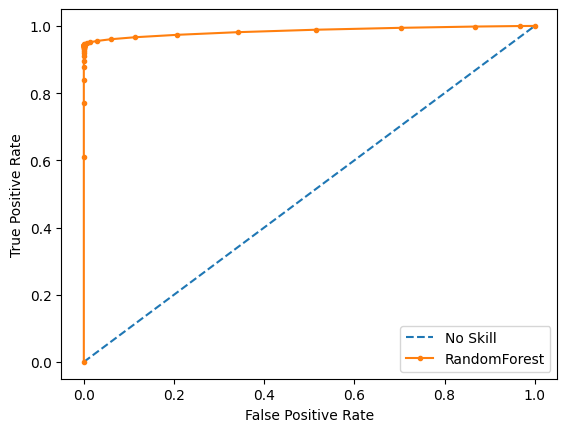

In [32]:


# Get predicted probabilities
y_prob = best_rf_model.predict_proba(X_test)

# Create a DataFrame to store the probabilities
pred_df = pd.DataFrame(y_prob, columns=['PROB_0', 'PROB_1'])

# Assuming class 1 is the positive class
pred_df['PROB'] = pred_df['PROB_1']

# No skill prediction (random guessing)
ns_probs = [0 for _ in range(len(y_test))]

# Calculate AUC scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, pred_df["PROB"])

# Calculate ROC curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, pred_df["PROB"])

# Plot the ROC curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='RandomForest')

# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Show the legend
plt.legend()

# Show the plot
plt.show()


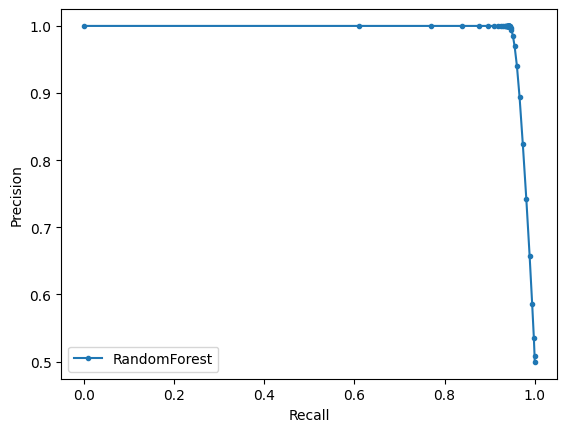

In [33]:


# Assuming pred_df is already defined and contains the predicted probabilities
lr_precision, lr_recall, _ = precision_recall_curve(y_test, pred_df["PROB"])

# Plot the Precision-Recall curve
plt.plot(lr_recall, lr_precision, marker='.', label='RandomForest')

# Axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

# Show the legend
plt.legend()

# Show the plot
plt.show()


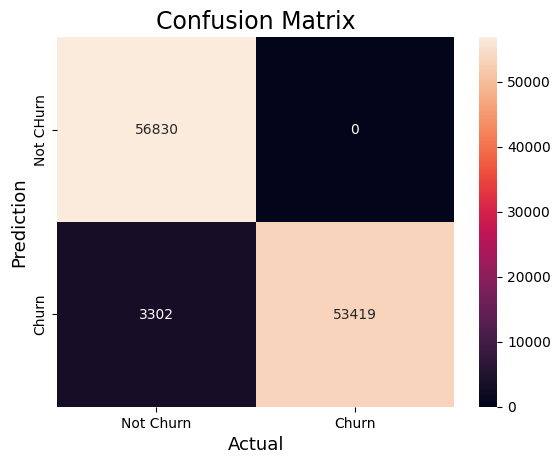

In [34]:
cm = confusion_matrix(y_test,y_pred)
 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Not Churn','Churn'],
            yticklabels=['Not CHurn','Churn'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [36]:
# Add predictions to pred_df
pred_df['PREDICTION'] = y_pred

# Create scores_data DataFrame
scores_data = pd.DataFrame({
    "ns_probs": ns_probs,
    "y_test": y_test,
    "y_pred": pred_df["PREDICTION"],
    "act_probs": pred_df["PROB"]
})

# Display the first few rows of scores_data to verify
print(scores_data.head())


   ns_probs  y_test  y_pred  act_probs
0         0       0       0       0.02
1         0       0       0       0.06
2         0       0       0       0.10
3         0       0       0       0.08
4         0       0       0       0.00


In [37]:
scores_data.to_csv("scores.csv", index=False)

In [38]:
# Define or use the prediction function
def model_prediction_score_func(dataframe):
    # Ensure 'dataframe' has the correct features required by the model
    return pipeline.predict(dataframe)  # Use your trained pipeline/model here
 
# Assuming df is your input DataFrame with the necessary features
Original_df['Model_Output'] = model_prediction_score_func(Original_df)

NameError: name 'pipeline' is not defined